# 1. Importing Vaex

Vaex is not automatically included with Google Colab. However, when I first installed it by `!pip install vaex` and imported it, I got the error:
```python
ContextualVersionConflict: (PyYAML 3.13 (/usr/local/lib/python3.7/dist-packages)
Requirement.parse('PyYAML>=5.1; extra == "standard"'), {'uvicorn'}) 
```
Turns out Google Colab is running a rather old version of IPython, therefore an upgrade is needed:
```
!pip install --upgrade ipython
```
Now the error is gone :)

Note that we're adding `%%timeit` preceding every cell to underline how **quick** vaex is.

In [ ]:
#!pip install --upgrade ipython
#!pip install vaex
# Uncomment 2 commands above when starting the notebook.
# Restart is required after installing. Then you can comment them again.

In [1]:
from google.colab import drive
import vaex
vaex.multithreading.thread_count_default = 8
import vaex.ml

In [ ]:
#!unzip main.zip -d ./deep_rl_trader

In [ ]:
%%time
df = vaex.from_csv('###############.csv') # Load your data
df.shape

Total: 78,562 datapoints (7142 x 11)

# 2. Column Definitions
As a good start, it cannot hurt to define some of the columns since it's not intuitive right away to non-technical readers.

Let's first analyze what the columns are by calling `df` `vaex.dataframe.DataFrame` object.

In [6]:
%%time
df

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.48 µs


#,Date,Time,Open,High,Low,Close,RSI,SMA(1),SMA(12),SMA(60),SMA(200)
0,20201109,30100,0.65293,0.65293,0.65293,0.65293,0Bv,0.65293,0.652930bbb,0.652930bbb,0.652930bbb
1,20201109,30300,0.65293,0.65293,0.65292,0.65292,0Bv,0.65292,0.652925abb,0.652925abb,0.652925abb
2,20201109,30400,0.6530199999999999,0.6544300000000001,0.6530199999999999,0.65442,0Bv,0.65442,0.653423bbb,0.653423bbb,0.653423bbb
3,20201109,30600,0.6542100000000001,0.6543100000000001,0.6542100000000001,0.65425,0Bv,0.65425,0.653630bbb,0.653630bbb,0.653630bbb
4,20201109,30700,0.6542100000000001,0.65433,0.65413,0.65433,0Bv,0.65433,0.653770bbb,0.653770bbb,0.653770bbb
...,...,...,...,...,...,...,...,...,...,...,...
"7,137",20201114,25500,0.6633899999999999,0.6634,0.66328,0.6632899999999999,31.41B,0.6632899999999999,0.663478abb,0.663568aab,0.663606aaa
"7,138",20201114,25600,0.6633,0.6633100000000001,0.66322,0.66327,30.36B,0.66327,0.663448abb,0.663561aab,0.663605aaa
"7,139",20201114,25700,0.66327,0.6632899999999999,0.6632399999999999,0.66325,29.3B,0.66325,0.663411abb,0.663553aab,0.663604aaa
"7,140",20201114,25800,0.66325,0.6632899999999999,0.66325,0.66327,31.86B,0.66327,0.663385abb,0.663545aab,0.663602aaa


* `Date` - Timestamp of the date of the trade of format `YYYYMMDD`.
* `Time` - Timestamp of the trade of format centiseconds. For example, 30100 means that particular row was generated on the 301st second of that day -- 5 minutes and 1 second. We might need a separate function to make sense of this.
* `Open` - Price of the forex which opens at the start of that timeframe.
* `High` - Highest reached price of the forex at that timeframe.
* `Low` - Lowest reached price of the forex at that timeframe.
* `Close` - Price of the forex which opens at the start of that timeframe.
* `RSI` - Relative Strength Index (RSI) is a measurement used by traders to assess the price momentum of a stock or other security. Any level below 30 is oversold, while an RSI of over 70 suggests the shares are overbought.
* `SMA(1)` - Single moving average of 1 timeframe (100 centiseconds)
* `SMA(12)` - Single moving average of 12 timeframes (1200 centiseconds)
* `SMA(60)` - Single moving average of 60 timeframes (6000 centiseconds)
* `SMA(200)` - Single moving average of 200 timeframes (20000 centiseconds)

# 3. Data Cleaning

We see that the last 3 columns have 3 alphabets appended behind the integers -- as well as the column `RSI` with 1 alphabet appended behind them. With this, we can't anyhow recognize them as numbers and `vaex` will recognize this as strings.

We also need to combine the `Date` and `Time` together in a valid `datetime` type. To prove my point, let's print `df.info()` and see which ones are string and which ones are numbers.

In [7]:
df.info()

column,type,unit,description,expression
Date,int64,,,
Time,int64,,,
Open,float64,,,
High,float64,,,
Low,float64,,,
Close,float64,,,
RSI,str,,,
SMA(1),float64,,,
SMA(12),str,,,
SMA(60),str,,,


## 3.1. Alphabet Slicing

In [8]:
%%time
df['SMA(200)'] = df['SMA(200)'].apply(lambda x: float(x[:-3]))
df['SMA(60)'] = df['SMA(60)'].apply(lambda x: float(x[:-3]))
df['SMA(12)'] = df['SMA(12)'].apply(lambda x: float(x[:-3]))

CPU times: user 4.1 ms, sys: 9 µs, total: 4.11 ms
Wall time: 6.1 ms


For some reason the `extract_regex()` function from the [documentation](https://vaex.io/docs/api.html) didn't work as intended. I tried using the method and it raised:
```python
AttributeError: 'Expression' object has no attribute 'extract_regex'
```
In this manner, I'm left no choice but to use the standard `re` package to find all float values from a given string.

In [9]:
%%time
import re
df['RSI'] = df['RSI'].apply(lambda x: float(re.findall(r"(?<![a-zA-Z:])[-+]?\d*\.?\d+", x)[0]))

df # The dataset looks like this now...

CPU times: user 719 µs, sys: 0 ns, total: 719 µs
Wall time: 694 µs


#,Date,Time,Open,High,Low,Close,RSI,SMA(1),SMA(12),SMA(60),SMA(200)
0,20201109,30100,0.65293,0.65293,0.65293,0.65293,0.0,0.65293,0.65293,0.65293,0.65293
1,20201109,30300,0.65293,0.65293,0.65292,0.65292,0.0,0.65292,0.652925,0.652925,0.652925
2,20201109,30400,0.6530199999999999,0.6544300000000001,0.6530199999999999,0.65442,0.0,0.65442,0.653423,0.653423,0.653423
3,20201109,30600,0.6542100000000001,0.6543100000000001,0.6542100000000001,0.65425,0.0,0.65425,0.65363,0.65363,0.65363
4,20201109,30700,0.6542100000000001,0.65433,0.65413,0.65433,0.0,0.65433,0.65377,0.65377,0.65377
...,...,...,...,...,...,...,...,...,...,...,...
"7,137",20201114,25500,0.6633899999999999,0.6634,0.66328,0.6632899999999999,31.41,0.6632899999999999,0.663478,0.663568,0.663606
"7,138",20201114,25600,0.6633,0.6633100000000001,0.66322,0.66327,30.36,0.66327,0.663448,0.663561,0.663605
"7,139",20201114,25700,0.66327,0.6632899999999999,0.6632399999999999,0.66325,29.3,0.66325,0.663411,0.663553,0.663604
"7,140",20201114,25800,0.66325,0.6632899999999999,0.66325,0.66327,31.86,0.66327,0.663385,0.663545,0.663602


## 3.2. `Datetime` Conversion

We now should convert the `time` column to hours/minutes using the `datetime` standard library, before finally integrating it to the `Date` column.

In [10]:
from datetime import date, datetime, time, timedelta
import numpy as np

We first transform `string` objects to `datetime` or `timedelta` objects.

In [11]:
%%time
df['Time'] = df['Time'].apply(lambda x: np.timedelta64(timedelta(seconds=(x/100))))
df['Date'] = df['Date'].apply(lambda x:
                              np.array(
                              datetime.strptime(str(x), "%Y%m%d"),
                              dtype=np.datetime64))

CPU times: user 1.28 ms, sys: 934 µs, total: 2.21 ms
Wall time: 2.23 ms


In [12]:
%%time
df['Date'] = df.Date + df.Time
df = df.drop(columns=['Time'])
df # Display the clean data

CPU times: user 12.8 ms, sys: 3.15 ms, total: 16 ms
Wall time: 17.3 ms


#,Date,Open,High,Low,Close,RSI,SMA(1),SMA(12),SMA(60),SMA(200)
0,2020-11-09 00:05:01.000000,0.65293,0.65293,0.65293,0.65293,0.0,0.65293,0.65293,0.65293,0.65293
1,2020-11-09 00:05:03.000000,0.65293,0.65293,0.65292,0.65292,0.0,0.65292,0.652925,0.652925,0.652925
2,2020-11-09 00:05:04.000000,0.6530199999999999,0.6544300000000001,0.6530199999999999,0.65442,0.0,0.65442,0.653423,0.653423,0.653423
3,2020-11-09 00:05:06.000000,0.6542100000000001,0.6543100000000001,0.6542100000000001,0.65425,0.0,0.65425,0.65363,0.65363,0.65363
4,2020-11-09 00:05:07.000000,0.6542100000000001,0.65433,0.65413,0.65433,0.0,0.65433,0.65377,0.65377,0.65377
...,...,...,...,...,...,...,...,...,...,...
"7,137",2020-11-14 00:04:15.000000,0.6633899999999999,0.6634,0.66328,0.6632899999999999,31.41,0.6632899999999999,0.663478,0.663568,0.663606
"7,138",2020-11-14 00:04:16.000000,0.6633,0.6633100000000001,0.66322,0.66327,30.36,0.66327,0.663448,0.663561,0.663605
"7,139",2020-11-14 00:04:17.000000,0.66327,0.6632899999999999,0.6632399999999999,0.66325,29.3,0.66325,0.663411,0.663553,0.663604
"7,140",2020-11-14 00:04:18.000000,0.66325,0.6632899999999999,0.66325,0.66327,31.86,0.66327,0.663385,0.663545,0.663602


The issue is that with our current data, we don't have any volume data to calculate `vwap` (volume weighted average price) -- so I think this particular variable can be changed to `SMA(200)` instead to facilitate average prices within the maximum range.

We can also drop unrepresentative columns that are not in the sample dataset used to provide shape consistency: `RSI`, `SMA(1)`, `SMA(12)` and `SMA(60)`.

In [13]:
# Basically reshaping the data to take the form of the sample in the Github
df = df.drop(columns = ['RSI', 'SMA(1)', 'SMA(12)', 'SMA(60)'])
df.rename('SMA(200)', 'vwap')
df.rename('Open', 'open')
df.rename('High', 'high')
df.rename('Low', 'low')
df.rename('Close', 'close')
df.rename('Date', 'timestamp')
df['volume'] = df['vwap'] * 400 # Sample volume
to_insert = 'XBTUSD'
df['symbol'] = np.repeat(to_insert, len(df))
df

#,timestamp,open,high,low,close,vwap,volume,symbol
0,2020-11-09 00:05:01.000000,0.65293,0.65293,0.65293,0.65293,0.65293,261.172,XBTUSD
1,2020-11-09 00:05:03.000000,0.65293,0.65293,0.65292,0.65292,0.652925,261.17,XBTUSD
2,2020-11-09 00:05:04.000000,0.6530199999999999,0.6544300000000001,0.6530199999999999,0.65442,0.653423,261.3692,XBTUSD
3,2020-11-09 00:05:06.000000,0.6542100000000001,0.6543100000000001,0.6542100000000001,0.65425,0.65363,261.452,XBTUSD
4,2020-11-09 00:05:07.000000,0.6542100000000001,0.65433,0.65413,0.65433,0.65377,261.508,XBTUSD
...,...,...,...,...,...,...,...,...
"7,137",2020-11-14 00:04:15.000000,0.6633899999999999,0.6634,0.66328,0.6632899999999999,0.663606,265.4424,XBTUSD
"7,138",2020-11-14 00:04:16.000000,0.6633,0.6633100000000001,0.66322,0.66327,0.663605,265.442,XBTUSD
"7,139",2020-11-14 00:04:17.000000,0.66327,0.6632899999999999,0.6632399999999999,0.66325,0.663604,265.4416,XBTUSD
"7,140",2020-11-14 00:04:18.000000,0.66325,0.6632899999999999,0.66325,0.66327,0.663602,265.4408,XBTUSD


In [ ]:
df.info()

## 3.3. Exporting onto .hdf5
We export to either .csv or HDF5 object, before we configure an environment where the data is split onto training and test files as done in the sample.

In [15]:
train = df.sample(frac=0.7)
train.export_csv('./deep_rl_trader/main/real_data/train/train.csv')
#train.export_hdf5('./deep_rl_trader/main/real_data/train/train.hdf5')

In [17]:
test = df.sample(frac=0.3)
test.export_csv('./deep_rl_trader/main/real_data/test/test.csv')
#test.export_hdf5('./deep_rl_trader/main/real_data/test/test.hdf5')

# 4. Plugging the Model
Issues and changes to the original implementation:
1. A lot of inconsistencies in the `requirements.txt` file in which some modules cannot be imported. For instance, `anaconda_client==1.6.0` is not available. Therefore, installing requirements via `pip install -r requirements.txt` is strongly advised against. Instead, call:
```
!cat deep_rl_trader/requirements.txt | xargs -n 1 pip install
```
2. The package `talib` does not provide easy installation via `pip`. This will return:
```
Failed building wheel for TA-Lib #4245
```
So that we need to first download the `.tar.bz2` file in the environment -- and configure `numpy` to take at **least** version `1.20.00`. Otherwise, `talib` will return:
```
ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 88 from C header, got 80 from PyObject
```
This is yet another reason not to install directly from `requirements.txt` as some of the packages are either obsolete, deprecated of their functionality, or both 🥵
3. Install `Keras`, not `keras`, with:
```
!pip install Keras==2.1.2
!pip install keras-rl==0.4.2
```
The version used in this model is way different than the one integrated with Google Colab -- figures since the repo was last updated in 2018.
4. `pandas.stats` in the file `ta.py` was deprecated, so in return, we change all occurences of `moments` with `pd` and delete the line where we import `pandas.stats`.
5. `data/train` and `data/test` on `main()` was changed to read as a subfolder of `deep_rl_trader`. As well as the `info` and `model` subfolders.
6. Again, I think that the version used is obsolete and doesn't support old methods. Running the script provides:
```python
AttributeError: module 'tensorflow' has no attribute 'get_default_graph'
```
A bit of Googling and it turns out that we should import the model from `tensorflow` and not `keras`. We have to have a perfect environment for the whole thing to work -- that means downgrading the existing tensorflow integration:
```
%tensorflow_version 1.14.0
```
Or install the required version:
```
!pip install tensorflow==1.14.0
```
7. The original `create_model()` function does not return the `model` object -- so when initializing it, the script returns:
```
AttributeError: 'NoneType' object has no attribute 'summary'
```
One way to fix this was to return `model` at the end of the function.
8. Updating the `core.py` file in:
```
/usr/local/lib/python3.7/dist-packages/rl/
```
To the one within:
```
/content/main/deep_rl_trader/modified_keras_rl_core/
```
Seems to fix [this](https://github.com/miroblog/deep_rl_trader/issues/2) issue.
9. Again, compatibility issue. Using `CuDNNLSTM` returns a vague error:
```
Errors may have originated from an input operation. Input Source operations connected to node cu_dnnlstm_1/CudnnRNN
```
This is maybe because TensorFlow automatically configures standard off-the-shelf LSTM to be CuDNNLSTM unless specified otherwise. So, the main functional layer(s) should be only `keras.layers.LSTM` instead of `keras.layers.CuDNNLSTM`.

10. Final changes made to take in `hdf5` format on the `TraderEnv.py` file within class method `OhlcvEnv.load_from_csv()` to maximize Vaex performance. Whilst the method still says `load_from_csv()`, the workings inside are loading `hdf5`. Why didn't I change the method name altogether? I'm afraid it'll mess with the `main()` method and some other method I don't know about.

11. Specified `nb_steps=10000` and `nb_max_episode_steps=10000` when fitting the model in `ddqn_rl_trader.py` as per John's request to facilitate 10000 epochs.

**Note to self: Change the respective `.py` files to the one I changed manually on local machine** 

In [ ]:
# Run this entire cell to import packages without setup.
!pip install tensorflow==1.14.0
!pip uninstall numpy
!pip install numpy==1.20.00
!pip install Keras==2.1.2
!pip install keras-rl==0.4.2
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h516909a_0.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py37ha21ca33_2.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.7/dist-packages/ lib/python3.7/site-packages/talib --strip-components=3
import talib

In [ ]:
import tensorflow.compat.v1 as tf
!python deep_rl_trader/main/ddqn_rl_trader.py

# 5. Visualization 

Visualization implements the same wrapper function(s) as the one in `visualize_trade.py` on the main repository. However, I added `plt.figure(figsize=(12,15))` to better visualize the ups and downs of the model.

For the record, red means sell, and green means buy.

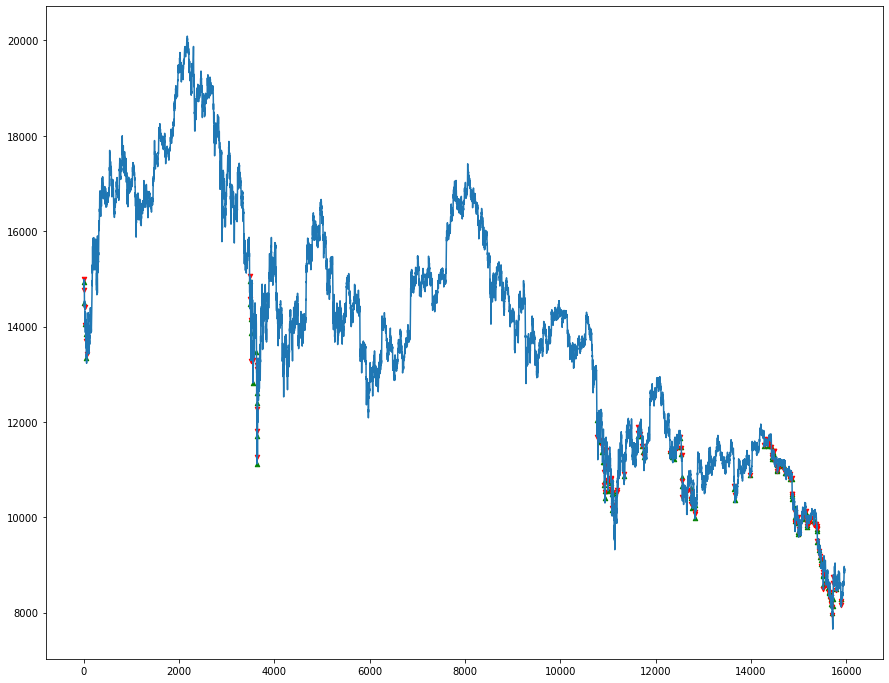

In [ ]:
# Visualization
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import time

def show_mdd(xs): # xs is cumulative return / portfolio , if reward u should
    # xs = df['reward'].cumsum() / if reward
    i = np.argmax(np.maximum.accumulate(xs) - xs) # end of the period
    j = np.argmax(xs[:i]) # start of period
    plt.figure(figsize=(12,15))
    plt.plot(xs)
    plt.plot([i, j], [xs[i], xs[j]], 'o', color='Red', markersize=10)
    plt.show()

def visualize(info):
    closes = [data[2] for data in info['history']]
    closes_index = [data[1] for data in info['history']]
    # buy tick
    buy_tick = np.array([data[1] for data in info['history'] if data[0] == 0])
    buy_price = np.array([data[2] for data in info['history'] if data[0] == 0])
    sell_tick = np.array([data[1] for data in info['history'] if data[0] == 1])
    sell_price = np.array([data[2] for data in info['history'] if data[0] == 1])

    plt.figure(figsize=(15,12))
    plt.plot(closes_index, closes)
    plt.scatter(buy_tick, buy_price - 2, c='g', marker="^", s=20)
    plt.scatter(sell_tick, sell_price + 2, c='r', marker="v", s=20)
    plt.show(block=True)
    time.sleep(3)

def get_file(dir):
  list_of_files = glob.glob(dir+'*') # * means all if need specific format then *.csv
  latest_file = max(list_of_files, key=os.path.getctime)
  return str(latest_file)

FILENAME = get_file('./deep_rl_trader/main/info/')
info = np.load(FILENAME, allow_pickle=True).all()
visualize(info)

# 5. Results
The results are in! We ran the code for 2 episodes, each episode consisting of 10000 epochs each (as mentioned in 3 point 11.)

First episode:
* Runtime: **33.026 seconds**
* Entry: 1,000,000 KRW (838.69 USD)
* Exit: 2,642,730 KRW (2,223.37 USD)
* Percentage profit: 264.273% (2.64 fold)
* Net profit: 1,642,730 KRW (1,382.05 USD)

Second episode:
* Runtime: **28.662 seconds**
* Entry: 1,000,000 KRW (838.69 USD)
* Exit: 8,265,654.74 KRW (6,932.36 USD)
* Percentage profit: 826.56% (8.2656 fold)
* Net profit: 7,265,654.74 KRW (6,109.96 USD)